## Emily's state transition function

In [79]:
import Pkg
Pkg.add("Plots")
using Plots

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


In [80]:
include("state.jl")

TR (generic function with 1 method)

## MCTS Functions

In [99]:
# A shortened representation of MDP that works for online planning (no full state-space, TR captures T and R)
struct MDP 
    gamma # Discount factor
    A # Action space
    TR # Transition model
end 

In [82]:
struct MonteCarloTreeSearch
    P
    N   # visit count
    Q   # action-value estimate
    d   # depth to go through for the Monte Carlo search
    d_r # depth to go through the rollout at the end of the MCTS
    m   # num of simulations
    c   # exploration constant 
    U   # value function estimate 
end 

function (π::MonteCarloTreeSearch)(s)
    for k in 1:π.m
        simulate!(π,s)
    end 
    return argmax(a->π.Q[(s,a)], π.P.A)
end 

function simulate!(π::MonteCarloTreeSearch, s, d=π.d)
    if d <= 0 
        return rollout(π.P, s, π.d_r)
    end 
    P, N, Q, c = π.P, π.N, π.Q, π.c
    A, TR, gamma = P.A, P.TR, P.gamma
    
    if !haskey(N,(s,first(A)))  # if (s,a) has never been visited
        for a in A 
            N[(s,a)] = 0 
            Q[(s,a)] = 0
        end 
        return rollout(π.P, s, π.d_r)   
    end 
    
    # if (s,a) has been visited
    a = explore(π,s)
    s_, r = TR(s,a) 
    q = r + gamma* simulate!(π, s_, d-1) 
    N[(s,a)] += 1  # +1 for visit count 
    Q[(s,a)] += (q-Q[(s,a)]) / N[(s,a)]  # The more you visited, the update of the Q will (usually) converge 
    return q 
end 

bonus(Nsa, Ns) = Nsa==0 ? Inf : sqrt(log(Ns)/Nsa)

function explore(π::MonteCarloTreeSearch, s)
    A, N, Q, c = π.P.A, π.N, π.Q, π.c
    Ns = sum(N[(s,a)] for a in A)
    # objective = Q+bonus term 
    # if there is no past visit, then that exploration is always prioritized 
    return argmax(a -> Q[(s,a)] + c*bonus(N[(s,a)], Ns), A)  
end 

function rollout(P, s, d)
    ret = 0.0 
    for t in 1:d
        a = rand(P.A)
        s, r = P.TR(s, a)
        ret += P.gamma^(t-1) * r
    end 
    return ret 
end


explore (generic function with 1 method)

## Run the problem with Stochastic Actions

In [83]:

# Create an intial state
x0 = 0 # checl: are the test points centered around x=0?
y0 = 0
dydt = 1
alt = 50
attitude = (0, 0)
target_list, n_targets = create_target_list("../src/obs_site.csv")

state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))
# print(state)
# create action list
""" 
Action space:
1 -> Do nothing OR: rotate to neutral/some intermediate position
2 -> Image target 1
.
.
.
n+1 -> Image target n 
"""
A = 1:n_targets+1 
reward_total = 0
state_list = []
for t = 0:60
    global state
    state_copy = copy(state)
    push!(state_list, state_copy)
    state, reward = TR(state, rand(A))
    reward_total += reward
end
println(reward_total)

Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Already observed this target. Doing nothing.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Already observed this target. Doing nothing.
Slewing to target and imaging.
Slewing to target and imaging.
Slewing to target and imaging.
Already observed this target. Doing nothing.
Slewing to target and imaging.
Slewing to target and imagin

## Run the given problem with MCTS

In [84]:
# Create an intial state
x0 = 0 # checl: are the test points centered around x=0?
y0 = 0
dydt = 1
alt = 50
attitude = (0, 0)
target_list, n_targets = create_target_list("../src/obs_site.csv")
state = State(x0, y0, dydt, alt, attitude, target_list, zeros(n_targets))

action_space =  1:n_targets+1 
gamma = 0.95

# reward model is not needed because TR does it
# simulation count
m = 10

# exploration constant
c = 1

# depths
d = 10
d_r = 3

Q = Dict{Tuple{State, Int}, Float64}()
N = Dict{Tuple{State, Int}, Int}()
U = Dict{State, Float64}()

# Q, N, and U are going to be difficult to define
P = MDP(gamma, action_space, TR)
mcts_run = MonteCarloTreeSearch(P, N, Q, d, d_r, m, c, U)

reward_total = 0
state_list_mcts = []
for t = 0:60
    # Push to the full list
    state_copy = copy(state)
    push!(state_list_mcts, state_copy)

    # Run MCTS
    state_for_mcts = copy(state)
    println("MCTS state before it runs")
    println(state_for_mcts)
    mcts_action = mcts_run(state_for_mcts)
    println("MCTS state after it runs")
    println(state_for_mcts)

    # Use the action
    println("Action being taken")
    println(mcts_action)
    state, reward = TR(state, mcts_action)
    reward_total += reward
end
println(reward_total)

MCTS state before it runs
State(0, 0, 1, 50, (0, 0), [(14.96, 19.4, 0.24), (-5.96, -26.72, 0.18), (17.98, -4.2, 0.56), (-11.53, 4.58, 0.49), (-14.05, 50.63, 0.16), (-13.45, 14.06, 0.15), (17.59, -50.14, 0.23), (10.64, -24.22, 0.96), (-10.13, -2.12, 0.72), (0.41, -17.92, 0.99), (7.99, 15.23, 0.78), (-3.73, 13.31, 0.16), (6.75, -30.91, 0.82), (16.73, -58.67, 0.48), (13.01, 44.44, 0.46), (14.89, -5.33, 0.54), (12.0, 38.66, 0.05), (-13.81, -57.73, 0.57), (15.25, -17.04, 0.43), (-8.04, -27.74, 0.7), (19.03, -22.45, 0.91), (-3.4, 51.01, 0.03), (13.24, 31.47, 0.28), (-13.19, 4.34, 0.96), (-4.73, -51.53, 0.2), (-13.74, 12.25, 0.33), (2.5, 24.89, 0.72), (-4.36, -6.89, 0.52), (18.9, 17.49, 0.65), (9.73, -47.02, 0.6), (-19.6, -22.35, 0.65), (-3.99, 54.1, 0.03), (-17.78, -31.8, 0.18), (0.65, 8.11, 0.97), (2.72, 52.97, 0.4), (17.9, -59.05, 0.34), (8.66, -55.91, 0.88), (0.47, 1.08, 0.47), (4.02, 56.83, 0.79), (-10.76, -35.95, 0.87), (-4.05, -43.79, 0.2), (10.93, 48.84, 0.43), (7.25, 56.88, 0.04), (1

Excessive output truncated after 524302 bytes.

), (19.0, 36.15, 0.2), (-8.39, 23.56, 0.5), (-2.83, 19.74, 0.92), (-10.72, 21.41, 0.42), (9.52, -45.78, 0.43), (9.8, -40.21, 0.92), (-16.27, 53.97, 0.56), (-11.53, 58.15, 0.45), (-12.44, 13.7, 0.72), (-18.25, 14.87, 0.41), (6.51, -5.88, 0.29), (3.42, -36.86, 0.28), (17.45, -7.9, 0.81), (11.79, -55.39, 0.94), (-1.9, 32.09, 0.02), (17.61, -13.17, 0.97), (14.96, 32.52, 0.5), (-11.9, -26.96, 0.74), (-6.58, -25.24, 0.62), (-17.18, 43.86, 0.86), (-1.45, 18.06, 0.06), (14.75, 26.52, 0.02)], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
Out of sl

## Plotting results

In [90]:
x_list = zeros(length(state_list))
y_list = zeros(length(state_list))
x_angle_list = []
y_angle_list = []
index = 1:length(state_list)
for i in 1:length(state_list)
    x_list[i] = state_list[i].x
    y_list[i] = state_list[i].y
    push!(x_angle_list, state_list[i].attitude[1])
    push!(y_angle_list, state_list[i].attitude[2])
end

x_list_mcts = zeros(length(state_list_mcts))
y_list_mcts = zeros(length(state_list_mcts))
x_angle_list_mcts = []
y_angle_list_mcts = []
index_mcts = 1:length(state_list_mcts)
for i in 1:length(state_list_mcts)
    x_list_mcts[i] = state_list_mcts[i].x
    y_list_mcts[i] = state_list_mcts[i].y
    push!(x_angle_list_mcts, state_list_mcts[i].attitude[1])
    push!(y_angle_list_mcts, state_list_mcts[i].attitude[2])
end


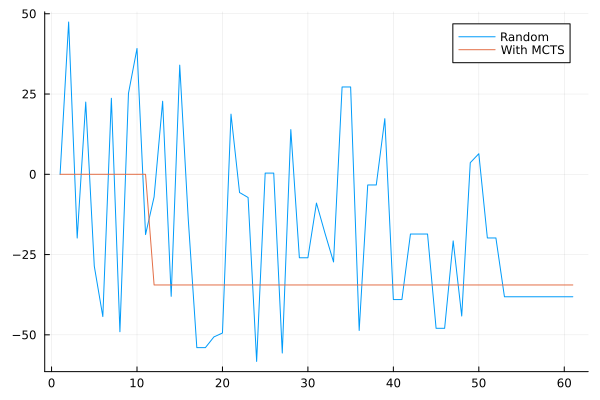

In [97]:
plot(index, [y_angle_list, y_angle_list_mcts], label=["Random" "With MCTS"])


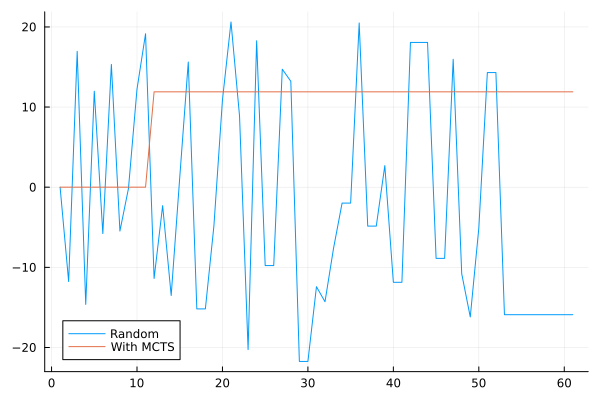

In [98]:
plot(index, [x_angle_list, x_angle_list_mcts], label=["Random" "With MCTS"])

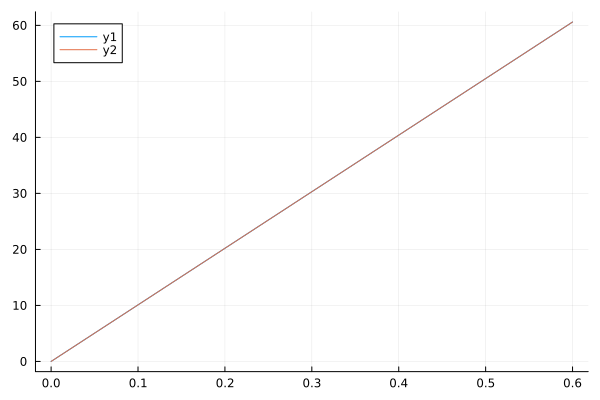

In [88]:
plot([x_list, x_list_mcts], [y_list, y_list_mcts])
